In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

import bt_mle_utils as mle
from simulation_utils import *

## Barbell

In [2]:
E = random_edge(5,5,10)
np.sum(E)

10.0

In [3]:
A = get_barbell_adj(n1 = 3, n2 = 5, bridge = 1)
A

array([[0., 1., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 0., 1., 1.],
       [0., 0., 0., 1., 1., 1., 0., 1.],
       [0., 0., 0., 1., 1., 1., 1., 0.]])

In [285]:
n1, n2 = 50, 50
bridge_list = np.arange(50) * 50
lam2_list = []
min_n_ij_list = []
B = 10
for bridge in bridge_list:
    lam, n_ij = 0, 0
    for b in range(B):
        A = get_barbell_adj(n1 = n1, n2 = n2, bridge = bridge)
        lam2, lamn = lambda2_A(A)
        lam += lam2 / B
        n_ij += min_n_ij(A) / B
    lam2_list.append(lam)
    min_n_ij_list.append(n_ij)
lam2_list = np.array(lam2_list)
min_n_ij_list = np.array(min_n_ij_list)

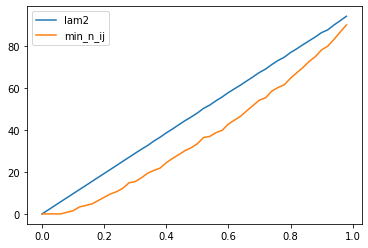

In [286]:
plt.plot(bridge_list / (n1 * n2), lam2_list)
plt.plot(bridge_list / (n1 * n2), min_n_ij_list)
plt.legend(['lam2','min_n_ij'])

In [4]:
t = 0.9
kappa = np.log(t / (1 - t))
kappa

2.1972245773362196

In [5]:
np.exp(4 * kappa)

6561.000000000005

In [6]:
kappa = 2.1
np.exp(kappa) / (1 + np.exp(kappa))

0.8909031788043871

In [52]:
n1, n2 = 50, 50
# bridge_list = np.arange(m) * 50
bridge_list = np.array([10, 25, 50, 75, 100, 200, 300, 400, 500, 800, 1200, 1600, 2000, 2400])
m = len(bridge_list)
B = 20

lam2_list = np.zeros(m)
min_n_ij_list = np.zeros(m)
n_max_list = np.zeros(m)
n_min_list = np.zeros(m)

bound_yan_list = np.zeros(m)
bound_shah_list = np.zeros(m)
bound_our_list = np.zeros(m)
bound_yan_nk_list = np.zeros(m)
bound_shah_nk_list = np.zeros(m)
bound_our_nk_list = np.zeros(m)

std_yan_list = np.zeros(m)
std_shah_list = np.zeros(m)
std_our_list = np.zeros(m)
std_yan_nk_list = np.zeros(m)
std_shah_nk_list = np.zeros(m)
std_our_nk_list = np.zeros(m)

bar_yan_list = np.zeros((m,2))
bar_shah_list = np.zeros((m,2))
bar_our_list = np.zeros((m,2))
bar_yan_nk_list = np.zeros((m,2))
bar_shah_nk_list = np.zeros((m,2))
bar_our_nk_list = np.zeros((m,2))

n = n1 + n2
# delta = np.log(n) / n
k = 10
t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta = get_beta_with_gap(n, delta)
beta *= kappa / (np.max(beta) - np.min(beta))
total = 5


l_infty_beta_list = np.zeros(m)
std_l_infty_beta_list = np.zeros(m)
bar_l_infty_beta_list = np.zeros((m,2))
rank_beta_list = np.zeros(m)
topk_beta_list = np.zeros(m)

np.random.seed(0)

for ix, bridge in enumerate(bridge_list):
    lam, n_ij = 0, 0
    
    l_infty_beta_, rank_beta_, topk_beta_ = np.zeros(B), np.zeros(B), np.zeros(B)
    lam2_, n_ij_, n_max_, n_min_ = np.zeros(B), np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_, bound_shah_, bound_our_ = np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_nk_, bound_shah_nk_, bound_our_nk_ = np.zeros(B), np.zeros(B), np.zeros(B)
    
    for b in range(B):
        A = get_barbell_adj(n1 = n1, n2 = n2, bridge = bridge)
        lam2_[b], n_ij_[b], n_max_[b], n_min_[b] = get_topo(A)
        
        edge_list = get_edge(A)
        game_matrix = get_game_matrix(beta, edge_list, total)
        
        beta_hat = get_mle_reg(game_matrix)
        l_infty_beta_[b], rank_beta_[b], topk_beta_[b] = get_error(beta, beta_hat, k = k)
        
        L = total
        bound_yan_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total)
        bound_shah_[b] = get_bound_shah(kappa, lam2_[b], n, L = total)
        bound_our_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L)
        
        bound_yan_nk_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total, no_kappa = True)
        bound_shah_nk_[b] = get_bound_shah(kappa, lam2_[b], n, L = total, no_kappa = True)
        bound_our_nk_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L, no_kappa = True)
        
        
        
    lam2_list[ix] = np.mean(lam2_)
    min_n_ij_list[ix] = np.mean(n_ij_)
    n_max_list[ix], n_min_list[ix] = np.mean(n_max_), np.mean(n_min_)
    bound_yan_list[ix] = np.mean(bound_yan_)
    bound_shah_list[ix] = np.mean(bound_shah_)
    bound_our_list[ix] = np.mean(bound_our_)
    bound_yan_nk_list[ix] = np.mean(bound_yan_nk_)
    bound_shah_nk_list[ix] = np.mean(bound_shah_nk_)
    bound_our_nk_list[ix] = np.mean(bound_our_nk_)
    
    std_yan_list[ix] = np.std(bound_yan_)
    std_shah_list[ix] = np.std(bound_shah_)
    std_our_list[ix] = np.std(bound_our_)
    std_yan_nk_list[ix] = np.std(bound_yan_nk_)
    std_shah_nk_list[ix] = np.std(bound_shah_nk_)
    std_our_nk_list[ix] = np.std(bound_our_nk_)
    
    bar_yan_list[ix,:] = np.quantile(bound_yan_, 0.05), np.quantile(bound_yan_, 0.95)
    bar_shah_list[ix, :] = np.quantile(bound_shah_, 0.05), np.quantile(bound_shah_, 0.95)
    bar_our_list[ix, :] = np.quantile(bound_our_, 0.05), np.quantile(bound_our_, 0.95)
    bar_yan_nk_list[ix, :] = np.quantile(bound_yan_nk_, 0.05), np.quantile(bound_yan_nk_, 0.95)
    bar_shah_nk_list[ix, :] = np.quantile(bound_shah_nk_, 0.05), np.quantile(bound_shah_nk_, 0.95)
    bar_our_nk_list[ix, :] = np.quantile(bound_our_nk_, 0.05), np.quantile(bound_our_nk_, 0.95)
    
    l_infty_beta_list[ix] = np.mean(l_infty_beta_)
    std_l_infty_beta_list[ix] = np.std(l_infty_beta_)
    bar_l_infty_beta_list[ix, :] = np.quantile(l_infty_beta_, 0.05), np.quantile(l_infty_beta_, 0.95)
    
    rank_beta_list = np.mean(rank_beta_)
    topk_beta_list = np.mean(topk_beta_)    
    
    print(bridge / (n1 * n2))

E:\python_notebook\ranking\bradley-terry\simulation_utils.py:149: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(kappa) / n_ij * np.sqrt(L * n * np.log(n + 1))
E:\python_notebook\ranking\bradley-terry\simulation_utils.py:147: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / n_ij * np.sqrt(L * n * np.log(n + 1))
c:\python\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\python\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


0.004
0.01
0.02
0.03
0.04
0.08
0.12
0.16
0.2
0.32
0.48
0.64
0.8
0.96


In [4]:
bound_yan_list

array([         inf,          inf,          inf,          inf,
                inf,          inf, 180.85957499,  89.73496556,
        55.04533735,  25.47628623,  14.09624458,   9.10070355,
         6.63966177,   4.98211475])

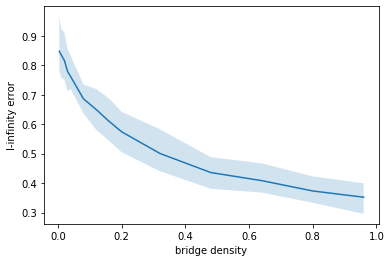

In [165]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l_infty_beta_list)
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
plt.savefig('barbell-3.pdf')

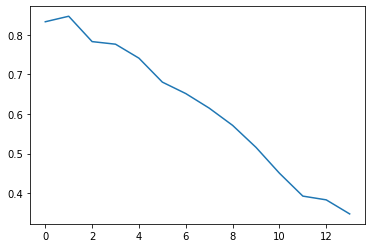

In [75]:
plt.plot(l_infty_beta_list)

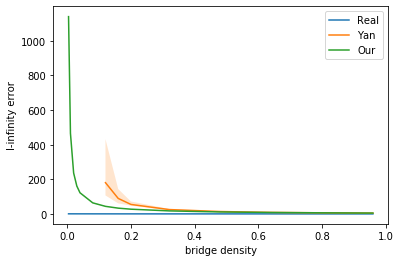

In [164]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l_infty_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
# plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_list[:,0], bar_our_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
# plt.legend(['Real','Yan','Shah','Our'])
plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
plt.savefig('barbell-1.pdf')

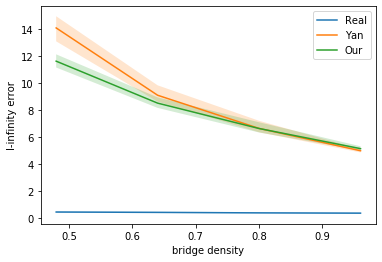

In [163]:
i = 10
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_l_infty_beta_list[i:,0], bar_l_infty_beta_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), l_infty_beta_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_yan_list[i:,0], bar_yan_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_list[i:])
# plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_our_list[i:,0], bar_our_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_list[i:])
# plt.legend(['Real','Yan','Shah','Our'])
plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
plt.savefig('barbell-2.pdf')

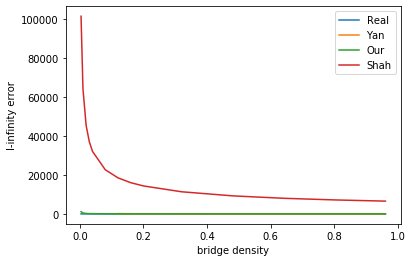

In [5]:
plt.plot(bridge_list / (n1 * n2), l_infty_beta_list)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.legend(['Real','Yan','Our','Shah'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
plt.savefig('barbell-1-2.pdf')

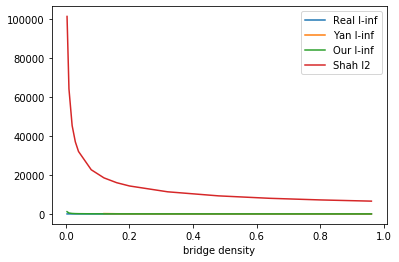

In [32]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l_infty_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_list[:,0], bar_our_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
plt.fill_between(bridge_list / (n1 * n2), bar_shah_list[:,0], bar_shah_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.legend(['Real l-inf','Yan l-inf','Our l-inf','Shah l2'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
# plt.ylabel('l-infinity error')
plt.savefig('barbell-1-2.pdf')

In [ ]:
# a factor to correct for finite sample values
factor = 1

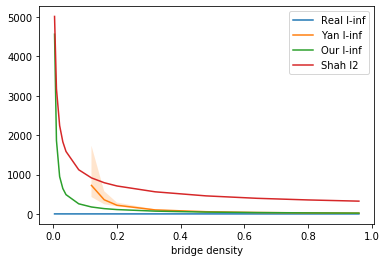

In [33]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l_infty_beta_list)
plt.fill_between(bridge_list / (n1 * n2), factor * bar_yan_list[:,0], factor * bar_yan_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), factor * bound_yan_list)
plt.fill_between(bridge_list / (n1 * n2), factor * bar_our_list[:,0], factor * bar_our_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), factor * bound_our_list)
factor_shah = np.exp(2 * kappa)
plt.fill_between(bridge_list / (n1 * n2), factor * bar_shah_nk_list[:,0] * factor_shah, 
                 factor * bar_shah_nk_list[:,1] * factor_shah, alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), factor * bound_shah_nk_list * factor_shah)
plt.legend(['Real l-inf','Yan l-inf','Our l-inf','Shah l2'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
# plt.ylabel('l-infinity error')
plt.savefig('barbell-2-2.pdf')

In [53]:
# a factor to correct for finite sample values
factor = 4

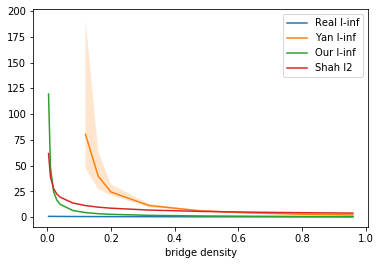

In [56]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l_infty_beta_list)
plt.fill_between(bridge_list / (n1 * n2), factor * bar_yan_nk_list[:,0], factor * bar_yan_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), factor * bound_yan_nk_list)
plt.fill_between(bridge_list / (n1 * n2), factor * bar_our_nk_list[:,0], factor * bar_our_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), factor * bound_our_nk_list)
plt.fill_between(bridge_list / (n1 * n2), factor * bar_shah_nk_list[:,0], factor * bar_shah_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), factor * bound_shah_nk_list)
plt.legend(['Real l-inf','Yan l-inf','Our l-inf','Shah l2'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
# plt.ylabel('l-infinity error')
plt.savefig('barbell-1-3.pdf')

In [25]:
len(bridge_list)

14

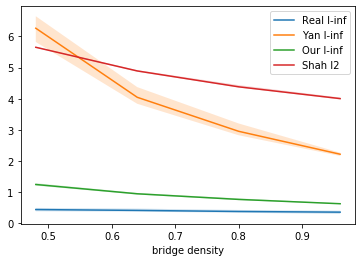

In [55]:
i = 10
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_l_infty_beta_list[i:,0], bar_l_infty_beta_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), l_infty_beta_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), factor * bar_yan_nk_list[i:,0], factor * bar_yan_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), factor * bound_yan_nk_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), factor * bar_our_nk_list[i:,0], factor * bar_our_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), factor * bound_our_nk_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), factor * bar_shah_nk_list[i:,0], factor * bar_shah_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), factor * bound_shah_nk_list[i:])
plt.legend(['Real l-inf','Yan l-inf','Our l-inf','Shah l2'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
# plt.ylabel('l-infinity error')
plt.savefig('barbell-2-3.pdf')

Text(0, 0.5, 'l-infinity error')

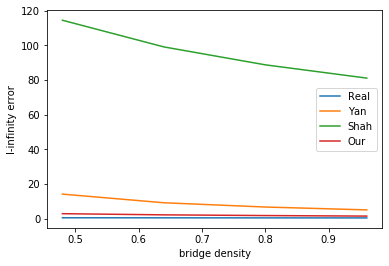

In [11]:
i = 10
plt.plot(bridge_list[i:] / (n1 * n2), l_infty_beta_list[i:])
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_list[i:])
plt.plot(bridge_list[i:] / (n1 * n2), bound_shah_nk_list[i:] * np.exp(2 * kappa))
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_nk_list[i:] * np.exp(kappa))
plt.legend(['Real l-inf','Yan l-inf','Our l-inf','Shah l2'])
plt.xlabel('bridge density')
# plt.ylabel('l-infinity error')
# plt.savefig('barbell-2.pdf')

# Island graph

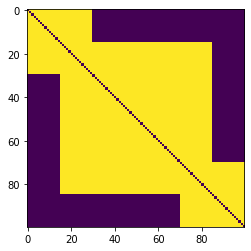

In [231]:
A = get_3island_adj()
plt.imshow(A)
# plt.savefig('adj_3island.pdf')

In [232]:
min_n_ij(A)

0.0

In [233]:
lam2, lamn = lambda2_A(A)
lam2

11.921134470680464

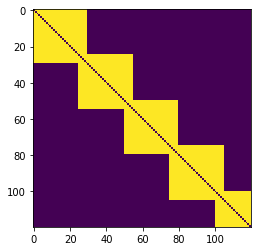

In [234]:
A = get_island_adj(n = 120)
plt.imshow(A)
# plt.savefig('adj_island.pdf')

In [235]:
min_n_ij(A)

0.0

In [236]:
lam2, lamn = lambda2_A(A)
lam2

1.1929892762754417

In [44]:
ni = 30
# bridge_list = np.arange(m) * 50
theta_list = np.array([1,2,4,8,12,16,20])
m = len(theta_list)
B = 20

lam2_list = np.zeros(m)
min_n_ij_list = np.zeros(m)
n_max_list = np.zeros(m)
n_min_list = np.zeros(m)

bound_yan_list = np.zeros(m)
bound_shah_list = np.zeros(m)
bound_our_list = np.zeros(m)
bound_yan_nk_list = np.zeros(m)
bound_shah_nk_list = np.zeros(m)
bound_our_nk_list = np.zeros(m)

std_yan_list = np.zeros(m)
std_shah_list = np.zeros(m)
std_our_list = np.zeros(m)
std_yan_nk_list = np.zeros(m)
std_shah_nk_list = np.zeros(m)
std_our_nk_list = np.zeros(m)

bar_yan_list = np.zeros((m,2))
bar_shah_list = np.zeros((m,2))
bar_our_list = np.zeros((m,2))
bar_yan_nk_list = np.zeros((m,2))
bar_shah_nk_list = np.zeros((m,2))
bar_our_nk_list = np.zeros((m,2))

bound_our_e_list = np.zeros(m)
std_our_e_list = np.zeros(m)
bar_our_e_list = np.zeros((m,2))

n = 100
# delta = np.log(n) / n
t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta = get_beta_with_gap(n, delta)
beta *= kappa / (np.max(beta) - np.min(beta))
total = 5
kappa_E = kappa * ni / n


l_infty_beta_list = np.zeros(m)
std_l_infty_beta_list = np.zeros(m)
bar_l_infty_beta_list = np.zeros((m,2))
rank_beta_list = np.zeros(m)
topk_beta_list = np.zeros(m)

np.random.seed(0)

for ix, theta in enumerate(theta_list):
    lam, n_ij = 0, 0
    
    l_infty_beta_, rank_beta_, topk_beta_ = np.zeros(B), np.zeros(B), np.zeros(B)
    lam2_, n_ij_, n_max_, n_min_ = np.zeros(B), np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_, bound_shah_, bound_our_ = np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_nk_, bound_shah_nk_, bound_our_nk_ = np.zeros(B), np.zeros(B), np.zeros(B)
    bound_our_e_ = np.zeros(B)
    
    for b in range(B):
        A = get_island_adj(ni = ni, no = theta, n = n)
        lam2_[b], n_ij_[b], n_max_[b], n_min_[b] = get_topo(A)
        
        edge_list = get_edge(A)
        game_matrix = get_game_matrix(beta, edge_list, total)
        
        beta_hat = get_mle_reg(game_matrix)
        l_infty_beta_[b], rank_beta_[b], topk_beta_[b] = get_error(beta, beta_hat, k = k)
        
        L = total
#         bound_yan_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total)
        bound_shah_[b] = get_bound_shah(kappa, lam2_[b], n, L = total)
        bound_our_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L)
        bound_our_e_[b] = get_bound_our(kappa_E, lam2_[b], n_max_[b], n_min_[b], n, L)
        
#         bound_yan_nk_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total, no_kappa = True)
        bound_shah_nk_[b] = get_bound_shah(kappa, lam2_[b], n, L = total, no_kappa = True)
        bound_our_nk_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L, no_kappa = True)
                
        
    lam2_list[ix] = np.mean(lam2_)
    min_n_ij_list[ix] = np.mean(n_ij_)
    n_max_list[ix], n_min_list[ix] = np.mean(n_max_), np.mean(n_min_)
#     bound_yan_list[ix] = np.mean(bound_yan_)
    bound_shah_list[ix] = np.mean(bound_shah_)
    bound_our_list[ix] = np.mean(bound_our_)
    bound_our_e_list[ix] = np.mean(bound_our_e_)
#     bound_yan_nk_list[ix] = np.mean(bound_yan_nk_)
    bound_shah_nk_list[ix] = np.mean(bound_shah_nk_)
    bound_our_nk_list[ix] = np.mean(bound_our_nk_)
    
#     std_yan_list[ix] = np.std(bound_yan_)
    std_shah_list[ix] = np.std(bound_shah_)
    std_our_list[ix] = np.std(bound_our_)
    std_our_e_list[ix] = np.std(bound_our_e_)
#     std_yan_nk_list[ix] = np.std(bound_yan_nk_)
    std_shah_nk_list[ix] = np.std(bound_shah_nk_)
    std_our_nk_list[ix] = np.std(bound_our_nk_)
    
#     bar_yan_list[ix,:] = np.quantile(bound_yan_, 0.05), np.quantile(bound_yan_, 0.95)
    bar_shah_list[ix, :] = np.quantile(bound_shah_, 0.05), np.quantile(bound_shah_, 0.95)
    bar_our_list[ix, :] = np.quantile(bound_our_, 0.05), np.quantile(bound_our_, 0.95)
    bar_our_e_list[ix, :] = np.quantile(bound_our_e_, 0.05), np.quantile(bound_our_e_, 0.95)
#     bar_yan_nk_list[ix, :] = np.quantile(bound_yan_nk_, 0.05), np.quantile(bound_yan_nk_, 0.95)
    bar_shah_nk_list[ix, :] = np.quantile(bound_shah_nk_, 0.05), np.quantile(bound_shah_nk_, 0.95)
    bar_our_nk_list[ix, :] = np.quantile(bound_our_nk_, 0.05), np.quantile(bound_our_nk_, 0.95)
    
    l_infty_beta_list[ix] = np.mean(l_infty_beta_)
    std_l_infty_beta_list[ix] = np.std(l_infty_beta_)
    bar_l_infty_beta_list[ix, :] = np.quantile(l_infty_beta_, 0.05), np.quantile(l_infty_beta_, 0.95)
    
    rank_beta_list = np.mean(rank_beta_)
    topk_beta_list = np.mean(topk_beta_)    
    
    print(theta)

1
2
4
8
12
16
20


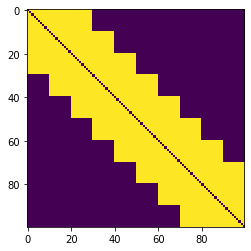

In [45]:
plt.imshow(A)

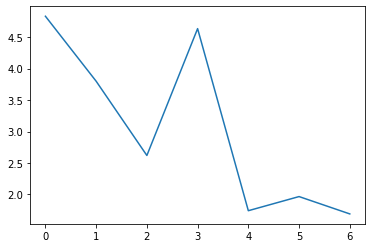

In [46]:
plt.plot(n_max_list / n_min_list)

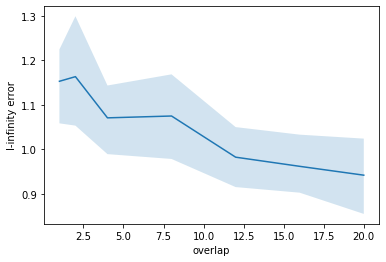

In [47]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(theta_list, bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(theta_list, l_infty_beta_list)
plt.xlabel('overlap')
plt.ylabel('l-infinity error')
plt.savefig('real_island.pdf')

In [48]:
np.exp(0.1)

1.1051709180756477

In [74]:
np.exp(kappa)

9.000000000000002

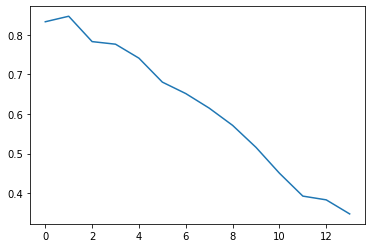

In [75]:
plt.plot(l_infty_beta_list)

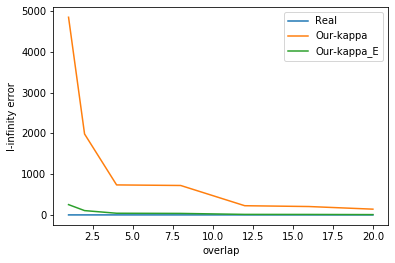

In [250]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(theta_list, bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(theta_list, l_infty_beta_list)
# plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
# plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.fill_between(theta_list, bar_our_list[:,0], bar_our_list[:,1], alpha = 0.2)
plt.plot(theta_list, bound_our_list)
plt.fill_between(theta_list, bar_our_e_list[:,0], bar_our_e_list[:,1], alpha = 0.2)
plt.plot(theta_list, bound_our_e_list)
# plt.legend(['Real','Yan','Shah','Our'])
plt.legend(['Real',
            
            'Our-kappa','Our-kappa_E'])
plt.xlabel('overlap')
plt.ylabel('l-infinity error')
plt.savefig('error_island.pdf')

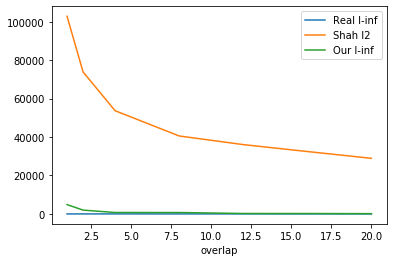

In [51]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(theta_list, bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(theta_list, l_infty_beta_list)
# plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
# plt.plot(bridge_list / (n1 * n2), bound_yan_list)
# plt.fill_between(theta_list, bar_shah_list[:,0], bar_shah_list[:,1], alpha = 0.2)
# plt.plot(theta_list, bound_shah_list)
factor_shah = np.exp(4 * kappa)
plt.fill_between(theta_list, bar_shah_nk_list[:,0] * factor_shah, bar_shah_nk_list[:,1] * factor_shah, alpha = 0.2)
plt.plot(theta_list, bound_shah_nk_list * factor_shah)

plt.fill_between(theta_list, bar_our_list[:,0], bar_our_list[:,1], alpha = 0.2)
plt.plot(theta_list, bound_our_list)
# plt.legend(['Real','Yan','Shah','Our'])
plt.legend(['Real l-inf','Shah l2','Our l-inf'])
plt.xlabel('overlap')
# plt.ylabel('l-infinity error')
plt.savefig('error_island-3.pdf')

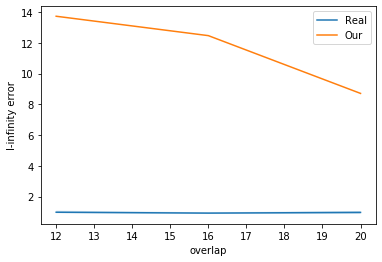

In [229]:
i = 4
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(theta_list[i:], bar_l_infty_beta_list[i:,0], bar_l_infty_beta_list[i:,1], alpha = 0.2)
plt.plot(theta_list[i:], l_infty_beta_list[i:])
# plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
# plt.plot(bridge_list / (n1 * n2), bound_yan_list)
# plt.plot(bridge_list / (n1 * n2), bound_shah_list)
# plt.fill_between(theta_list[i:], bar_our_list[i:,0], bar_our_list[i:,1], alpha = 0.2)
plt.fill_between(theta_list[i:], bound_our_list[i:] - std_our_list[i:], bound_our_list[i:] + std_our_list[i:], alpha = 0.2)
plt.plot(theta_list[i:], bound_our_list[i:])
# plt.legend(['Real','Yan','Shah','Our'])
plt.legend(['Real','Our'])
plt.xlabel('overlap')
plt.ylabel('l-infinity error')
plt.savefig('error_island-2.pdf')

In [217]:
std_our_list

array([9.09494702e-13, 2.27373675e-13, 1.13686838e-13, 1.13686838e-13,
       2.84217094e-14, 0.00000000e+00, 0.00000000e+00])

Text(0, 0.5, 'l-infinity error')

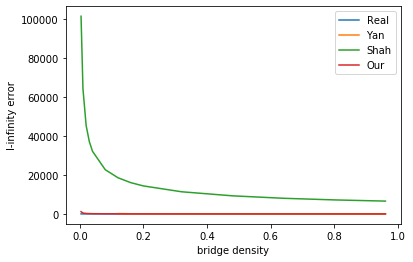

In [126]:
plt.plot(bridge_list / (n1 * n2), l_infty_beta_list)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
plt.legend(['Real','Yan','Shah','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

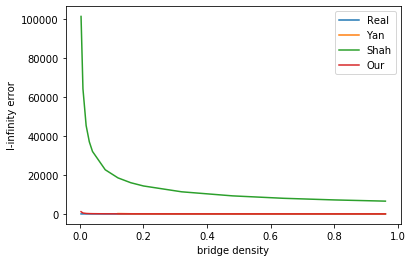

In [167]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l_infty_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.fill_between(bridge_list / (n1 * n2), bar_shah_list[:,0], bar_shah_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_list[:,0], bar_our_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

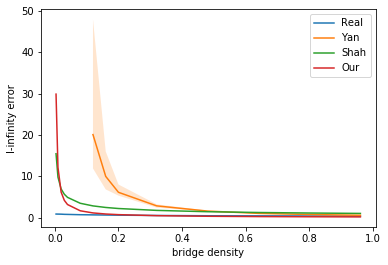

In [168]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l_infty_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_nk_list[:,0], bar_yan_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_nk_list)
plt.fill_between(bridge_list / (n1 * n2), bar_shah_nk_list[:,0], bar_shah_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_shah_nk_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_nk_list[:,0], bar_our_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_nk_list)
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

In [77]:
len(bridge_list)

14

Text(0, 0.5, 'l-infinity error')

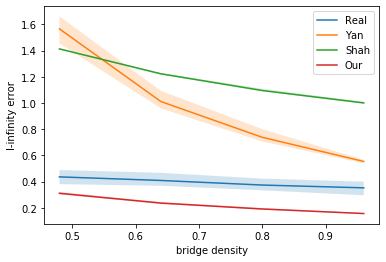

In [170]:
i = 10
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_l_infty_beta_list[i:,0], bar_l_infty_beta_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), l_infty_beta_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_yan_nk_list[i:,0], bar_yan_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_nk_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_shah_nk_list[i:,0], bar_shah_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_shah_nk_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_our_nk_list[i:,0], bar_our_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_nk_list[i:])
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

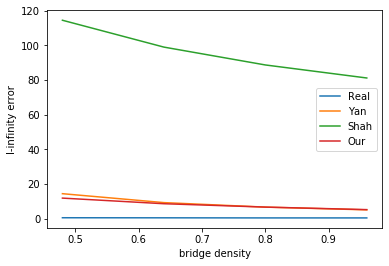

In [134]:
i = 10
plt.plot(bridge_list[i:] / (n1 * n2), l_infty_beta_list[i:])
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_list[i:])
plt.plot(bridge_list[i:] / (n1 * n2), bound_shah_nk_list[i:] * np.exp(2 * kappa))
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_list[i:])
plt.legend(['Real','Yan','Shah','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-2.pdf')

In [148]:
n1, n2 = 50, 50
# bridge_list = np.arange(m) * 50
bridge_list = np.array([10, 25, 50, 75, 100, 200, 300, 400, 500, 800, 1200, 1600, 2000, 2400])
m = len(bridge_list)
B = 20

lam2_list = np.zeros(m)
min_n_ij_list = np.zeros(m)
n_max_list = np.zeros(m)
n_min_list = np.zeros(m)

bound_yan_list = np.zeros(m)
bound_shah_list = np.zeros(m)
bound_our_list = np.zeros(m)
bound_yan_nk_list = np.zeros(m)
bound_shah_nk_list = np.zeros(m)
bound_our_nk_list = np.zeros(m)

std_yan_list = np.zeros(m)
std_shah_list = np.zeros(m)
std_our_list = np.zeros(m)
std_yan_nk_list = np.zeros(m)
std_shah_nk_list = np.zeros(m)
std_our_nk_list = np.zeros(m)

bar_yan_list = np.zeros((m,2))
bar_shah_list = np.zeros((m,2))
bar_our_list = np.zeros((m,2))
bar_yan_nk_list = np.zeros((m,2))
bar_shah_nk_list = np.zeros((m,2))
bar_our_nk_list = np.zeros((m,2))

bound_agar_list = np.zeros(m)
std_agar_list = np.zeros(m)
bar_agar_list = np.zeros((m,2))
bound_agar_list = np.zeros(m)
std_agar_list = np.zeros(m)
bar_agar_list = np.zeros((m,2))

n = n1 + n2
# delta = np.log(n) / n
k = 10
t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta = get_beta_with_gap(n, delta)
beta *= kappa / (np.max(beta) - np.min(beta))
total = 5

w = np.exp(beta)
w /= np.sum(w)
d_avg_list = np.zeros(m)


l_infty_beta_list = np.zeros(m)
std_l_infty_beta_list = np.zeros(m)
bar_l_infty_beta_list = np.zeros((m,2))
rank_beta_list = np.zeros(m)
topk_beta_list = np.zeros(m)

np.random.seed(0)

for ix, bridge in enumerate(bridge_list):
    lam, n_ij = 0, 0
    
    l_infty_beta_, rank_beta_, topk_beta_ = np.zeros(B), np.zeros(B), np.zeros(B)
    lam2_, n_ij_, n_max_, n_min_ = np.zeros(B), np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_, bound_shah_, bound_our_ = np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_nk_, bound_shah_nk_, bound_our_nk_ = np.zeros(B), np.zeros(B), np.zeros(B)
    bound_agar_, bound_agar_nk_ = np.zeros(B), np.zeros(B)
    
    for b in range(B):
        A = get_barbell_adj(n1 = n1, n2 = n2, bridge = bridge)
        lam2_[b], n_ij_[b], n_max_[b], n_min_[b] = get_topo(A)
        d
        
        edge_list = get_edge(A)
        game_matrix = get_game_matrix(beta, edge_list, total)
        
        beta_hat = get_mle_reg(game_matrix)
        l_infty_beta_[b], rank_beta_[b], topk_beta_[b] = get_error(beta, beta_hat, k = k)
        
        L = total
        bound_yan_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total)
        bound_shah_[b] = get_bound_shah(kappa, lam2_[b], n, L = total)
        bound_our_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L)
        
        bound_yan_nk_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total, no_kappa = True)
        bound_shah_nk_[b] = get_bound_shah(kappa, lam2_[b], n, L = total, no_kappa = True)
        bound_our_nk_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L, no_kappa = True)
        
        
        
    lam2_list[ix] = np.mean(lam2_)
    min_n_ij_list[ix] = np.mean(n_ij_)
    n_max_list[ix], n_min_list[ix] = np.mean(n_max_), np.mean(n_min_)
    bound_yan_list[ix] = np.mean(bound_yan_)
    bound_shah_list[ix] = np.mean(bound_shah_)
    bound_our_list[ix] = np.mean(bound_our_)
    bound_yan_nk_list[ix] = np.mean(bound_yan_nk_)
    bound_shah_nk_list[ix] = np.mean(bound_shah_nk_)
    bound_our_nk_list[ix] = np.mean(bound_our_nk_)
    
    std_yan_list[ix] = np.std(bound_yan_)
    std_shah_list[ix] = np.std(bound_shah_)
    std_our_list[ix] = np.std(bound_our_)
    std_yan_nk_list[ix] = np.std(bound_yan_nk_)
    std_shah_nk_list[ix] = np.std(bound_shah_nk_)
    std_our_nk_list[ix] = np.std(bound_our_nk_)
    
    bar_yan_list[ix,:] = np.quantile(bound_yan_, 0.05), np.quantile(bound_yan_, 0.95)
    bar_shah_list[ix, :] = np.quantile(bound_shah_, 0.05), np.quantile(bound_shah_, 0.95)
    bar_our_list[ix, :] = np.quantile(bound_our_, 0.05), np.quantile(bound_our_, 0.95)
    bar_yan_nk_list[ix, :] = np.quantile(bound_yan_nk_, 0.05), np.quantile(bound_yan_nk_, 0.95)
    bar_shah_nk_list[ix, :] = np.quantile(bound_shah_nk_, 0.05), np.quantile(bound_shah_nk_, 0.95)
    bar_our_nk_list[ix, :] = np.quantile(bound_our_nk_, 0.05), np.quantile(bound_our_nk_, 0.95)
    
    l_infty_beta_list[ix] = np.mean(l_infty_beta_)
    std_l_infty_beta_list[ix] = np.std(l_infty_beta_)
    bar_l_infty_beta_list[ix, :] = np.quantile(l_infty_beta_, 0.05), np.quantile(l_infty_beta_, 0.95)
    
    rank_beta_list = np.mean(rank_beta_)
    topk_beta_list = np.mean(topk_beta_)    
    
    print(bridge / (n1 * n2))

c:\python\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
c:\python\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in double_scalars
c:\python\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\python\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


0.004
0.01
0.02
0.03
0.04
0.08
0.12
0.16
0.2
0.32
0.48
0.64
0.8
0.96


In [70]:
bound_yan_list

array([          inf,           inf,           inf,           inf,
                 inf,           inf, 1297.00093616,  640.67728783,
        426.02020167,  208.47379834,  108.83084738,   72.28964191,
         52.73630414,   39.89668645])

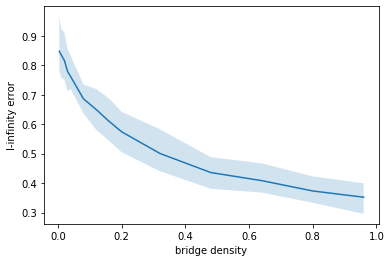

In [165]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l_infty_beta_list)
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
plt.savefig('barbell-3.pdf')

In [73]:
np.exp(0.1)

1.1051709180756477

In [74]:
np.exp(kappa)

9.000000000000002

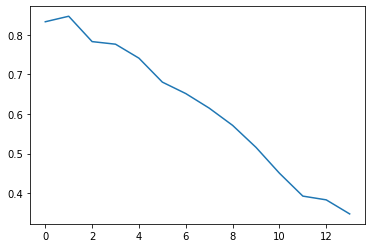

In [75]:
plt.plot(l_infty_beta_list)

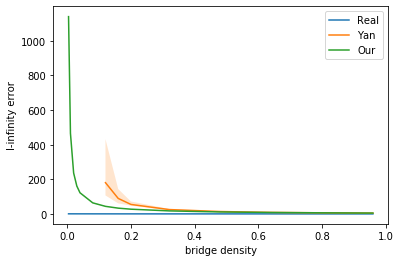

In [164]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l_infty_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
# plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_list[:,0], bar_our_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
# plt.legend(['Real','Yan','Shah','Our'])
plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
plt.savefig('barbell-1.pdf')

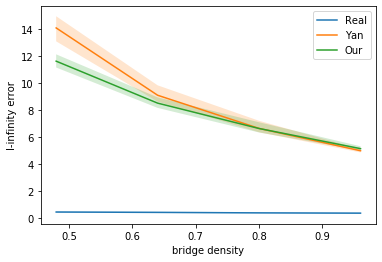

In [163]:
i = 10
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_l_infty_beta_list[i:,0], bar_l_infty_beta_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), l_infty_beta_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_yan_list[i:,0], bar_yan_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_list[i:])
# plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_our_list[i:,0], bar_our_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_list[i:])
# plt.legend(['Real','Yan','Shah','Our'])
plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
plt.savefig('barbell-2.pdf')

Text(0, 0.5, 'l-infinity error')

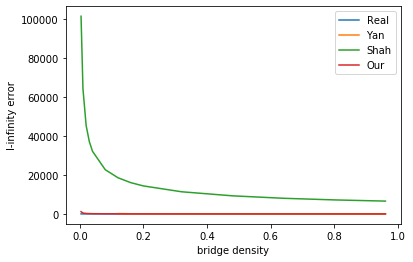

In [126]:
plt.plot(bridge_list / (n1 * n2), l_infty_beta_list)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
plt.legend(['Real','Yan','Shah','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

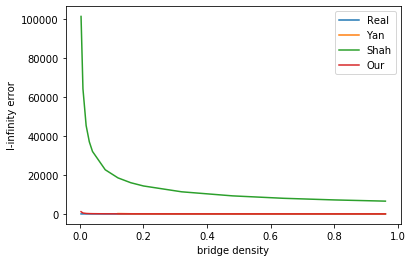

In [167]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l_infty_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_list[:,0], bar_yan_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_list)
plt.fill_between(bridge_list / (n1 * n2), bar_shah_list[:,0], bar_shah_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_shah_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_list[:,0], bar_our_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_list)
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

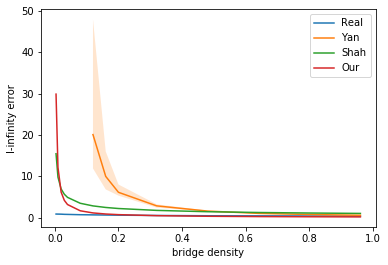

In [168]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list / (n1 * n2), bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), l_infty_beta_list)
plt.fill_between(bridge_list / (n1 * n2), bar_yan_nk_list[:,0], bar_yan_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_yan_nk_list)
plt.fill_between(bridge_list / (n1 * n2), bar_shah_nk_list[:,0], bar_shah_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_shah_nk_list)
plt.fill_between(bridge_list / (n1 * n2), bar_our_nk_list[:,0], bar_our_nk_list[:,1], alpha = 0.2)
plt.plot(bridge_list / (n1 * n2), bound_our_nk_list)
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

In [77]:
len(bridge_list)

14

Text(0, 0.5, 'l-infinity error')

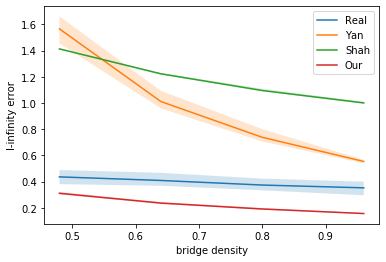

In [170]:
i = 10
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_l_infty_beta_list[i:,0], bar_l_infty_beta_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), l_infty_beta_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_yan_nk_list[i:,0], bar_yan_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_nk_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_shah_nk_list[i:,0], bar_shah_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_shah_nk_list[i:])
plt.fill_between(bridge_list[i:] / (n1 * n2), bar_our_nk_list[i:,0], bar_our_nk_list[i:,1], alpha = 0.2)
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_nk_list[i:])
plt.legend(['Real','Yan','Shah','Our'])
# plt.legend(['Real','Yan','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

Text(0, 0.5, 'l-infinity error')

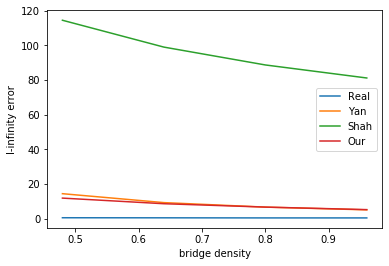

In [134]:
i = 10
plt.plot(bridge_list[i:] / (n1 * n2), l_infty_beta_list[i:])
plt.plot(bridge_list[i:] / (n1 * n2), bound_yan_list[i:])
plt.plot(bridge_list[i:] / (n1 * n2), bound_shah_nk_list[i:] * np.exp(2 * kappa))
plt.plot(bridge_list[i:] / (n1 * n2), bound_our_list[i:])
plt.legend(['Real','Yan','Shah','Our'])
plt.xlabel('bridge density')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-2.pdf')

## cayley graph, topology

In [264]:
def get_k_cayley_adj(n, k, permute = False):
    # k-cayley graph
    adj = np.zeros((n,n))
    for i in range(n):
        for j in range(1, k + 1):
            col = (i + j) % n
            adj[i, col] = 1
            
            col = (i - j) % n
            adj[i, col] = 1
    if permute:
        P = np.zeros((n,n))
        P[np.arange(n), np.random.permutation(n)] = 1
        adj = P.T @ adj @ P
    return adj

In [267]:
A = get_k_cayley_adj(10, 2, permute = False)
A

array([[0., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
       [1., 1., 0., 0., 0., 0., 0., 1., 1., 0.]])

In [253]:
def lambda2_k_cayley(n, k):
    A = get_k_cayley(n, k, permute = False, info = 'adj')
    La = np.diag(np.sum(A, axis = 0)) - A
    lambdas = np.linalg.eigvalsh(La)
    return lambdas[1], lambdas[-1]

def cos_sum(n, k):
    return 2 * k - 2 * (np.sum(np.cos(np.arange(1, k + 1) * 2 * np.pi / n)))

In [254]:
def min_n_ij(A):
    return np.min(A @ A)

In [257]:
n = 1000
k_list = np.arange(30) * 10
lam2_list = []
appr_list = []
for k in k_list:
    lam2, lamn = lambda2_k_cayley(n = n, k = k)
    lam2_list.append(lam2)
    appr_list.append(4 / 3 * np.pi**2 * (k)**3 / n**2)

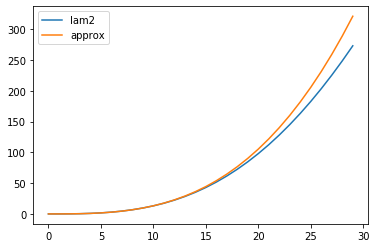

In [258]:
plt.plot(lam2_list)
plt.plot(appr_list)
plt.legend(['lam2', 'approx'])

In [259]:
n = 1000
k = 103
lam2, lamn = lambda2_k_cayley(n = n, k = k)
print(lam2)
print(4 / 3 * np.pi**2 * (k)**3 / n**2)
print(2/3 * np.pi**2 * k * (k + 1) * (2*k + 1) / n**2)
print(2 * np.pi * k**3 / n**2)

print(cos_sum(n, k))
print((2*k)**0.5)

14.284403155337708
14.379710944518894
14.589801923536749
6.865806231158428
14.284403155337941
14.352700094407323
